# ADA Homework 03 - Interactive Viz

In [693]:
# Import libraries
import pandas as pd
import numpy as np

# Map
import folium

# Query with geonames
import json
import requests
from urllib import parse 
from urllib.request import urlopen

# Ignore warning in order to reduce noise for reviewers
import warnings
warnings.filterwarnings('ignore')

# folium (for map representation of results) 
import folium

# json
import json
from pprint import pprint

> **Assignemnt**

> Build a Choropleth map which shows intuitively (i.e., use colors wisely) how much grant money goes to each Swiss canton. To do so, you will need to use the provided TopoJSON file, combined with the Choropleth map example you can find in the Folium README file.

## 1. Import data

In [694]:
# The data was downloaded from: http://p3.snf.ch/Pages/DataAndDocumentation.aspx and store locally.
# The downloaded csv file use semi-colons ';' as delimeter and contains
# the column header has first row
p3_grand = pd.read_csv("Data/P3_GrantExport.csv", sep=";", index_col=0)
p3_grand.head()

,Project Title,Project Title English,Responsible Applicant,Funding Instrument,Funding Instrument Hierarchy,Institution,University,Discipline Number,Discipline Name,Discipline Name Hierarchy,Start Date,End Date,Approved Amount,Keywords
"﻿""Project Number""",,,,,,,,,,,,,,
1,Schlussband (Bd. VI) der Jacob Burckhardt-Biog...,NaN,Kaegi Werner,Project funding (Div. I-III),Project funding,NaN,Nicht zuteilbar - NA,10302,Swiss history,Human and Social Sciences;Theology & religious...,01.10.1975,30.09.1976,11619.00,NaN
4,Batterie de tests à l'usage des enseignants po...,NaN,Massarenti Léonard,Project funding (Div. I-III),Project funding,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,10104,Educational science and Pedagogy,"Human and Social Sciences;Psychology, educatio...",01.10.1975,30.09.1976,41022.00,NaN
5,"Kritische Erstausgabe der ""Evidentiae contra D...",NaN,Kommission für das Corpus philosophorum medii ...,Project funding (Div. I-III),Project funding,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",10101,Philosophy,Human and Social Sciences;Linguistics and lite...,01.03.1976,28.02.1985,79732.00,NaN
6,Katalog der datierten Handschriften in der Sch...,NaN,Burckhardt Max,Project funding (Div. I-III),Project funding,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,10302,Swiss history,Human and Social Sciences;Theology & religious...,01.10.1975,30.09.1976,52627.00,NaN
7,Wissenschaftliche Mitarbeit am Thesaurus Lingu...,NaN,Schweiz. Thesauruskommission,Project funding (Div. I-III),Project funding,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",10303,Ancient history and Classical studies,Human and Social Sciences;Theology & religious...,01.01.1976,30.04.1978,120042.00,NaN


In [695]:
p3_grand.index.is_unique #the project number is unique, thus we keep it as the index of our table

True

The data contains 15 columns. Among these columns, there are 8 columns containing some 'NaN' values.

In [696]:
p3_grand.isnull().any()

Project Title                   False
Project Title English            True
Responsible Applicant           False
Funding Instrument              False
Funding Instrument Hierarchy     True
Institution                      True
University                       True
Discipline Number               False
Discipline Name                 False
Discipline Name Hierarchy        True
Start Date                       True
End Date                         True
Approved Amount                 False
Keywords                         True
dtype: bool

## 2. Data filter and cleaning

### 2.1 Column Selection

In order to draw the Choropleth map, we need to have the canton locations and the grant amount from the data.<br>
We will use column ***Institution*** and ***University*** to get canton locations later, as for the grant amount, we keep the column ***Approved Amount***.

In [697]:
data_of_interest = p3_grand[['Institution', 'University', 'Approved Amount']]
data_of_interest.head()

,Institution,University,Approved Amount
"﻿""Project Number""",,,
1,NaN,Nicht zuteilbar - NA,11619.00
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.00
5,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.00
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.00
7,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.00


### 2.2 Data Filtering 

#### 2.2.1 Unusable names
Some cells in the column **University** contains the value ** Nicht zuteilbar - NA **. According to Google Translate, "Nicht zuteilbar" means "Not Assignable", which we interpret as no university could be assigned to that data. Thus we have no choice but to filter out all cells contain *Nicht zuteilbar - NA* in their **University** field.

Similar problem occurs with the following values:
<ul>
    <li> Weitere Institute - FINST -->  *Other Institutes*</li>
    <li> Firmen/Privatwirtschaft - F --> *Business / Private*</li>
    <li> Weitere Spitäler - ASPIT --> *Other hospitals*</li>
    <li> NPO (Biblioth., Museen, Verwalt.) - NPO  --> Non Profit Organisation, so no location extractable here</li>
</ul>

We will not be able to extract a canton location from these **University** or **Institution** names. Therefore, we set both of these cells to 'None' for further cleaning. 

NB: This step required human intervention

In [698]:
names_to_remove = ['Nicht zuteilbar - NA',
                   'Weitere Institute - FINST',
                   'Firmen/Privatwirtschaft - FP',
                   'Weitere Spitäler - ASPIT', 
                   'NPO (Biblioth., Museen, Verwalt.) - NPO']

# These values will be replaced by the 'None' value (will be remove after)
none_values = [None] * len(names_to_remove)

data_of_interest.replace(names_to_remove, none_values, inplace=True)
data_of_interest.head()

,Institution,University,Approved Amount
"﻿""Project Number""",,,
1,NaN,None,11619.00
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.00
5,Kommission für das Corpus philosophorum medii ...,None,79732.00
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.00
7,Schweiz. Thesauruskommission,None,120042.00


#### 2.2.2 Remove na values
We can see that some row have neither *Institution* or *University* information.

In [699]:
data_of_interest.loc[20008]

Institution                            NaN
University                             NaN
Approved Amount    data not included in P3
Name: 20008, dtype: object

These row are therefore useless for us, so we can remove them.

In [700]:
# We can use the 'thresh=2' because we know that the column 'Approved Amount' doesn't contain null values.
# Drop the row if it contains 2 na_values (NaN or None) in both column University and Institution
data_of_interest.dropna(axis=0, how="all", thresh=2, inplace=True)
data_of_interest.shape

(59966, 3)

Note that even if the ***University*** field is not valid, the row may be keepee, since we may be able to use the column ***Institution*** to find some locations information.

#### 2.2.3 Amount is not a string
As seen above, the column *Approved Amount* has no null values. But it doesn't only contains number...

In [701]:
data_of_interest['Approved Amount'].describe()

count                       59966
unique                      35482
top       data not included in P3
freq                        10244
Name: Approved Amount, dtype: object

As we can see, some rows contains a string *"data not included in P3"*. We have no choice but to delete rows which contain this value in the **Approved Amount** column. We only keep rows where the *Approved Amount* value can be cast to numeric.

In [702]:
# The "errors=coerce" will replace all values that cannot be cast to numeric by a null value.
# So we simply need to get ride of all these null values
data_of_interest['Approved Amount'] = pd.to_numeric(data_of_interest['Approved Amount'], errors="coerce")
missing_amount = data_of_interest['Approved Amount'].isnull()
data_clean = data_of_interest[~ missing_amount]

print("Type of 'Approved Amount' column:", data_clean['Approved Amount'].dtypes)
print("Any null values? ",data_clean['Approved Amount'].isnull().any())
data_clean.head()

Type of 'Approved Amount' column: float64
Any null values?  False


,Institution,University,Approved Amount
"﻿""Project Number""",,,
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.0
5,Kommission für das Corpus philosophorum medii ...,None,79732.0
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.0
7,Schweiz. Thesauruskommission,None,120042.0
8,"Séminaire de politique économique, d'économie ...",Université de Fribourg - FR,53009.0


In [703]:
data_clean.shape

(49722, 3)

## 3. Add "Canton" information 

Based on the **Institution** and **University** information, we will try to find the corresponding **Canton** information for each row.

In [704]:
# The list of Universities with the corresponding number of entries
a = data_clean.groupby('University').size()
print("Total:", a.sum())
a.sort_values(ascending=False)

Total: 46194


University
Universität Zürich - ZH                               6754
Université de Genève - GE                             6379
ETH Zürich - ETHZ                                     6143
Universität Bern - BE                                 5460
Universität Basel - BS                                4737
EPF Lausanne - EPFL                                   4406
Université de Lausanne - LA                           4090
Université de Fribourg - FR                           2078
Université de Neuchâtel - NE                          1589
Paul Scherrer Institut - PSI                           537
Universität St. Gallen - SG                            426
Università della Svizzera italiana - USI               346
Eidg. Anstalt für Wasserversorgung - EAWAG             333
HES de Suisse occidentale - HES-SO                     271
Zürcher Fachhochschule (ohne PH) - ZFH                 260
Eidg. Material und Prüfungsanstalt - EMPA              238
Fachhochschule Nordwestschweiz (ohne PH) - FH

### 3.0 Retrieving Canton names

Based on the json file we will use later on with Folium map, we create an array with all cantons of Switzerland.

In [705]:
with open('Data/ch-cantons.topojson.json') as data_file:    
    data = json.load(data_file)
    
# Canton_data will contain the canton code (two letters) and the canton name. 
# In case of a bilingual canton, we store the name in two language (e.g. French and german)
canton_data = []

for i in range(len(data["objects"]['cantons']['geometries'])):
    canton = []
    
    # canton code
    canton.append(data["objects"]['cantons']['geometries'][i]['id'])
    
    # canton name
    name = data["objects"]['cantons']['geometries'][i]['properties']['name']
    name=name.split('/')
    canton.append(name[0])
    
    if (len(name) > 1): # if bilingual canton
        canton.append(name[1])
    
    # Add to general array
    canton_data.append(canton)
    

canton_data

[['ZH', 'Zürich'],
 ['BE', 'Bern', 'Berne'],
 ['LU', 'Luzern'],
 ['UR', 'Uri'],
 ['SZ', 'Schwyz'],
 ['OW', 'Obwalden'],
 ['NW', 'Nidwalden'],
 ['GL', 'Glarus'],
 ['ZG', 'Zug'],
 ['FR', 'Fribourg'],
 ['SO', 'Solothurn'],
 ['BS', 'Basel-Stadt'],
 ['BL', 'Basel-Landschaft'],
 ['SH', 'Schaffhausen'],
 ['AR', 'Appenzell Ausserrhoden'],
 ['AI', 'Appenzell Innerrhoden'],
 ['SG', 'St. Gallen'],
 ['GR', 'Graubünden', 'Grigioni'],
 ['AG', 'Aargau'],
 ['TG', 'Thurgau'],
 ['TI', 'Ticino'],
 ['VD', 'Vaud'],
 ['VS', 'Valais', 'Wallis'],
 ['NE', 'Neuchâtel'],
 ['GE', 'Genève'],
 ['JU', 'Jura']]

### 3.1 Retrieve Canton based on University column
First, we will use the **University** field to try to retrieve it's **Canton** information.
We start by creating a Dataframe with all Universitiy names as the index.

In [706]:
df = pd.DataFrame()
df['University'] = data_clean.University.unique()
df.index = df['University']
df.head()

,University
University,
Université de Genève - GE,Université de Genève - GE
NaN,None
Universität Basel - BS,Universität Basel - BS
Université de Fribourg - FR,Université de Fribourg - FR
Universität Zürich - ZH,Universität Zürich - ZH


Some of these university value are compose of two parts (separate by an hypen): ***University Name*** and ***University "Code"***.
Therefore we split each of these values. If no split possible, set *University Code* to *None*

In [707]:
institution = "**Institution**"
no_value = "**no_value"

df['University Name'] = None
df['University Code'] = None

# interate through the rows and split the university cell if possible
for index, row in df.iterrows():
    
    x = row.University
    if x == x and x: # Assert x is not Nan nor None
        try:
            a,b = x.split('-')
        except:
            a,b = x,no_value
    else:
        # x is NaN, but the 'Instition' value is not!
        a = b = institution
    
    row['University Name'] = a
    row['University Code'] = b
        
df.head()

,University,University Name,University Code
University,,,
Université de Genève - GE,Université de Genève - GE,Université de Genève,GE
NaN,None,**Institution**,**Institution**
Universität Basel - BS,Universität Basel - BS,Universität Basel,BS
Université de Fribourg - FR,Université de Fribourg - FR,Université de Fribourg,FR
Universität Zürich - ZH,Universität Zürich - ZH,Universität Zürich,ZH


#### With GeoNames
Now we try to use **GeoNames** API to search and retrieve canton information for each University.

In [708]:
geonames_url = 'http://api.geonames.org/search?q='
geonames_url_param = '&country=CH&maxRows=1&username=epfl_interactive_viz&type=json'

def getCanton(name):
    """ Retrieve the Canton information for a given place
    
        @param name: place's name. Must be in Switzerland
        
        @return The canton's string if found or False, otherwise.
    """
    
    url = geonames_url + name + geonames_url_param
    query = parse.quote(url, safe=':/&=?')
    js = json.loads(requests.get(query).text)

    try:
        # Canton information is stored under 'adminCode1' in the JSON given by GeoNames
        return [ js['geonames'][0]['adminCode1'], js['geonames'][0]['lng'], js['geonames'][0]['lat'] ]
    except:
        return False

First we try to find the canton information with the *University Name* information. If *GeoNames* isn't helpful, we try again, but with the ***University Code*** information.

In [709]:
# Add new columns to df
df['Canton'] = None
df['Lng'] = None
df['Lat'] = None

for index, row in df.iterrows():
    name = row['University Name']
    code = row['University Code']
    
    info = getCanton(row['University Name'])
    if not info: # Geonames with the 'University Name' returns false
        info = getCanton(row['University Code']) # Try to retrieve with the 'University Code'
    
    if info: # If Canton is not null
        row['Canton'] = info[0]
        row['Lng'] = info[1]
        row['Lat'] = info[2]
        
df.head()

,University,University Name,University Code,Canton,Lng,Lat
University,,,,,,
Université de Genève - GE,Université de Genève - GE,Université de Genève,GE,GE,6.14569,46.20222
NaN,None,**Institution**,**Institution**,None,None,None
Universität Basel - BS,Universität Basel - BS,Universität Basel,BS,BS,7.58403,47.55832
Université de Fribourg - FR,Université de Fribourg - FR,Université de Fribourg,FR,FR,7.15317,46.80683
Universität Zürich - ZH,Universität Zürich - ZH,Universität Zürich,ZH,ZH,8.53434,47.37092


#### Based on University Name

Some University contain, in their title, the name of the canton they are located in. For the ones Geonames wasn't useful, we try to use the information retrieve previously from the json file to map some more canton.

In [710]:
def canton_in_name(row, columnToCheck):
    """
        Fill the 'Canton' field if the columnToCheck contains it.
        
        @param row - Row of the dataframe
        @param columnToCheck - Institution or University
        
        @Return: Canton code if found, nothing otw
    """

    # If there is already a canton map, return it
    if row.Canton != None:
        return row.Canton
    
    
    x = row[columnToCheck]

    # Some rows may have NA value in the University field.
    if x==None or x!=x:
        return
    
    else:
        # we have a string to search if the data contain necessary information
        for c in canton_data:
            if c[1] in x:
                return c[0]
            else:
                # For bilingual cantons
                if len(c) > 2 and c[2] in x:
                    return c[0]
            
            
df['Canton'] = df.apply(canton_in_name, axis=1, args=["University"])

#### Merge Canton into Dataframe

Now that we have the canton information retrieved with *GeoNames* for somes Universities, we can create the column **Canton** in our data.

In [711]:
data_clean['Canton'] = None

for row in data_clean.itertuples():
    if row.University == row.University: # Assert that University is not null or NaN
        aa = df.loc[row.University, 'Canton']
        data_clean.set_value(row.Index,'Canton',aa)
        
data_clean.head()

,Institution,University,Approved Amount,Canton
"﻿""Project Number""",,,,
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.0,GE
5,Kommission für das Corpus philosophorum medii ...,None,79732.0,None
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.0,BS
7,Schweiz. Thesauruskommission,None,120042.0,None
8,"Séminaire de politique économique, d'économie ...",Université de Fribourg - FR,53009.0,FR


After this first step, we have 89.21% of canton information found.

In [712]:
1 - data_clean.Canton.isnull().sum() / data_clean.shape[0]

0.8921201882466514

### 3.2 Retrieve Canton based on Institution 

We still haven't use the ***Institution*** column: it's time to do so!
As we have tried to check in the canton information was contained in the university name, we will check if the instution name can help us.

In [713]:
data_clean[data_clean.Canton.isnull()].shape

(5364, 4)

In [714]:
# Try to retrieve more canton information based on the institution column.
data_clean['Canton'] = data_clean.apply(canton_in_name, axis=1, args=["Institution"])

In [715]:
1 - data_clean.Canton.isnull().sum() / data_clean.shape[0]

0.91150798439322633

Without manually map university with cities, we achieve 91.15 %.

### 3.3 Remove empty 'University'
Now, if we decided to get ride off all rows where we have not information about the university, we have 96.32%.

In [716]:
data_clean = data_clean[~ data_clean.University.isnull()]
1 - data_clean.Canton.isnull().sum() / data_clean.shape[0]

0.96322033164480236

### 3.4 Total Approved Amount per Canton

Groupby Cantons and sum up the Approved amount

In [717]:
df_canton = data_clean
# change type of the Approved Amount column to float
df_canton['Approved Amount'] = df_canton['Approved Amount'].astype('float')

df_canton = df_canton.groupby('Canton').sum()

df_canton['Canton'] = df_canton.index

df_canton

,Approved Amount,Canton
Canton,,
AG,1.154283e+08,AG
BE,1.553549e+09,BE
BL,4.277191e+07,BL
BS,1.352251e+09,BS
FR,4.582758e+08,FR
GE,1.850195e+09,GE
GR,1.834294e+06,GR
LU,5.492469e+07,LU
NE,3.832104e+08,NE


Some cantons had no approved amount according to the data we studied, add these to our table

In [718]:
i = df_canton.index.tolist()
for x in canton_data:
    if x[0] not in i:
        canton_entry = pd.DataFrame([[0, x[0]]], columns=['Approved Amount', 'Canton'])
        df_canton = df_canton.append(canton_entry)

# Switzerland has 26 cantons
df_canton.shape

(26, 2)

We change the unit of ***Approved Amount*** from CHF to Million CHF.

In [719]:
df_canton['Approved Amount'] = df_canton['Approved Amount'] / 1000000
df_canton.sort_values('Approved Amount', ascending=False)

,Approved Amount,Canton
Canton,,
ZH,3649.135803,ZH
VD,2361.789487,VD
GE,1850.194572,GE
BE,1553.549050,BE
BS,1352.251464,BS
FR,458.275817,FR
NE,383.210382,NE
AG,115.428286,AG
SG,88.286423,SG


## 4. Visualization

In [720]:
# Create the map and focus on Switzerland 
canton_map = folium.Map(location=[46.8, 8.28], zoom_start=8)

# Add Universities markers to the map, we were able to retrieve 
# precise geo data where university names were given. 
for univ, row in df.iterrows():
    if row.Lat != None:
        folium.Marker([row['Lat'], row['Lng']],
                   popup=univ, 
                   icon = folium.Icon(color = 'red', icon = 'glyphicon-book')).add_to(canton_map)

# Plot the map with colormap yellow orange red and manually set the scale. 
canton_map.choropleth(geo_path = canton_geo, 
                      data = df_canton,
                      columns = ['Canton', 'Approved Amount'],
                      key_on = 'feature.id',
                      topojson = 'objects.cantons',
                      threshold_scale = [0, 30, 200, 2000,3000, 4000],
                      fill_color = 'YlOrRd', 
                      fill_opacity = 0.7, 
                      line_opacity = 0.2,
                      legend_name = 'Approved Amount')

# Save the map for ease of access
canton_map.create_map(path='canton.html')

canton_map

### 5. Bonus

It is not perfect, since the separation of the Röstigraben is much more complex than simply dividing by cantons. We decided to have VS, JU, and Fr in French region and BE in german.

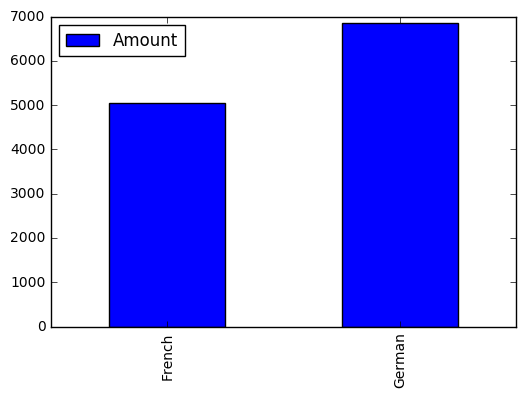

In [721]:
import matplotlib.pyplot as plt

french_canton = ['JU', 'GE', 'NE', 'VD', 'VS', 'FR']
german_canton = ['TG', 'AG', 'GR', 'SG', 'AI', 'AR', 'SH', 'BL',
                 'BS', 'SO', 'ZG', 'GL', 'NW', 'OW', 'SZ', 'UR',
                 'LU', 'BE', 'ZH']
 
df_french = df_canton[df_canton.Canton.isin(french_canton)]
french_sum = df_french['Approved Amount'].sum()

df_german = df_canton[df_canton.Canton.isin(german_canton)]
german_sum = df_german['Approved Amount'].sum()

rosti = [
    ["French", french_sum], 
    ['German', german_sum]
]

rostigraben = pd.DataFrame(rosti, index=["French", "German"], columns=["Region", "Amount"])
rostigraben.plot(kind='bar')
plt.show()

In [722]:
print("French region:", 
      "{0:.3f}".format(french_sum),
      "M CHF.-",
      "({0:.2f}".format(french_sum*100/(french_sum+german_sum)),
      "% of total)")

print("German region:",
      "{0:.3f}".format(german_sum),
      "M CHF.-",
      "({0:.2f}".format(german_sum*100/(french_sum+german_sum)),
      "% of total)")

French region: 5058.996 M CHF.- (42.43 % of total)
German region: 6863.810 M CHF.- (57.57 % of total)
